* 1) Prepare a classification model using Naive Bayes 
for salary data 

Data Description:

age -- age of a person
workclass	-- A work class is a grouping of work 
education	-- Education of an individuals	
maritalstatus -- Marital status of an individulas	
occupation	 -- occupation of an individuals
relationship -- 	
race --  Race of an Individual
sex --  Gender of an Individual
capitalgain --  profit received from the sale of an investment	
capitalloss	-- A decrease in the value of a capital asset
hoursperweek -- number of hours work per week	
native -- Native of an individual
Salary -- salary of an individual

In [59]:
!pip install category_encoders

In [288]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

## Loading Training Data

In [332]:
ds_train = pd.read_csv('SalaryData_Train.csv')
print(ds_train.shape)
ds_train.head()

(30161, 14)


,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [333]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30161 entries, 0 to 30160
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            30161 non-null  int64 
 1   workclass      30161 non-null  object
 2   education      30161 non-null  object
 3   educationno    30161 non-null  int64 
 4   maritalstatus  30161 non-null  object
 5   occupation     30161 non-null  object
 6   relationship   30161 non-null  object
 7   race           30161 non-null  object
 8   sex            30161 non-null  object
 9   capitalgain    30161 non-null  int64 
 10  capitalloss    30161 non-null  int64 
 11  hoursperweek   30161 non-null  int64 
 12  native         30161 non-null  object
 13  Salary         30161 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.2+ MB


In [334]:
print(ds_train.Salary.unique())
ds_train['Salary'].value_counts()

[' <=50K' ' >50K']


 <=50K    22653
 >50K      7508
Name: Salary, dtype: int64

<AxesSubplot:xlabel='Salary', ylabel='count'>

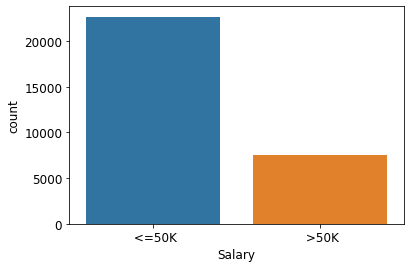

In [335]:
sns.countplot(ds_train['Salary'])

In [336]:
# fetching all categorical variables columns names
#categorylist = []
#for catvar in ds_train.columns:
#    if ds_train[catvar].dtype == 'object':
#        categorylist.append(catvar)
        
#print(categorylist)

# OR
# using list compression
categorylist = [ catvar for catvar in ds_train.columns  if ds_train[catvar].dtype == 'object']
categorylist

['workclass',
 'education',
 'maritalstatus',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native',
 'Salary']

In [337]:
print(len(categorylist))  # 9 categorical columns
print(ds_train[categorylist].columns)
ds_train[categorylist].head()

9
Index(['workclass', 'education', 'maritalstatus', 'occupation', 'relationship',
       'race', 'sex', 'native', 'Salary'],
      dtype='object')


,workclass,education,maritalstatus,occupation,relationship,race,sex,native,Salary
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [338]:
# checking for presence of junk character if any in columns
for colName in categorylist:
    #print(ds_train[colName].nunique())
    #print(ds_train[colName].value_counts())
    print("\ncolName = {} \n\n noOfClasses = {}\n{}".
          format(colName, ds_train[colName].nunique(),ds_train[colName].value_counts()))


colName = workclass 

 noOfClasses = 7
 Private             22285
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64

colName = education 

 noOfClasses = 16
 HS-grad         9840
 Some-college    6677
 Bachelors       5044
 Masters         1627
 Assoc-voc       1307
 11th            1048
 Assoc-acdm      1008
 10th             820
 7th-8th          557
 Prof-school      542
 9th              455
 12th             377
 Doctorate        375
 5th-6th          288
 1st-4th          151
 Preschool         45
Name: education, dtype: int64

colName = maritalstatus 

 noOfClasses = 7
 Married-civ-spouse       14065
 Never-married             9725
 Divorced                  4214
 Separated                  939
 Widowed                    827
 Married-spouse-absent      370
 Married-AF-spouse           21
Name: maritalstatus, dtype: int64

colName = occup

In [339]:
# using list comprehension for fetching numerical variables column names
numlist = [ numvar for numvar in ds_train.columns  if ds_train[numvar].dtype != 'object']
numlist

# checking for junk character if any in columns
for numColName in numlist:
    #print(ds_train[colName].nunique())
    #print(ds_train[colName].value_counts())
    print("\n{} \n\n noOfClasses = {}\n{}".format(numColName, ds_train[numColName].nunique(),ds_train[numColName].
                                                  value_counts()))


age 

 noOfClasses = 72
36    852
31    851
33    837
34    836
37    828
     ... 
82      7
83      5
85      3
88      3
86      1
Name: age, Length: 72, dtype: int64

educationno 

 noOfClasses = 16
9     9840
10    6677
13    5044
14    1627
11    1307
7     1048
12    1008
6      820
4      557
15     542
5      455
8      377
16     375
3      288
2      151
1       45
Name: educationno, dtype: int64

capitalgain 

 noOfClasses = 118
0        27623
15024      337
7688       270
7298       240
99999      148
         ...  
2387         1
4931         1
1455         1
401          1
2993         1
Name: capitalgain, Length: 118, dtype: int64

capitalloss 

 noOfClasses = 90
0       28735
1902      194
1977      162
1887      155
1848       50
        ...  
2457        1
2282        1
155         1
1944        1
1539        1
Name: capitalloss, Length: 90, dtype: int64

hoursperweek 

 noOfClasses = 94
40    14250
50     2718
45     1753
60     1405
35     1184
      ...  
92     

In [340]:
ds_train['age'].value_counts()
ds_train['age'].unique()

array([39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 23, 32, 34, 25, 43, 40,
       54, 35, 59, 56, 19, 20, 45, 22, 48, 21, 24, 57, 44, 41, 29, 47, 46,
       36, 79, 27, 18, 33, 76, 55, 61, 70, 64, 71, 66, 51, 58, 26, 17, 60,
       90, 75, 65, 77, 62, 63, 67, 74, 72, 69, 68, 73, 81, 78, 88, 80, 84,
       83, 85, 82, 86], dtype=int64)

In [341]:
ds_train['hoursperweek'].unique()

array([40, 13, 16, 45, 50, 80, 30, 35, 60, 20, 52, 44, 15, 25, 43, 38, 55,
       48, 58, 32, 70, 22, 56, 41, 28, 36, 24, 46,  2, 42, 12, 65,  1, 34,
       75, 98, 33, 54, 10,  6, 64, 19, 18, 72,  8,  9, 47, 37, 21, 26, 14,
        5,  7, 99, 53, 39, 62, 59, 57, 78, 90, 66, 11, 49, 84, 17, 68,  3,
       27, 85, 31, 51, 77, 63, 23,  4, 87, 88, 73, 89, 97, 94, 29, 96, 67,
       82, 86, 91, 81, 76, 92, 61, 74, 95], dtype=int64)

### Data Preprocessing

In [347]:
x = ds_train.iloc[:,:-1]
y = ds_train[['Salary']]
x

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30156,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
30157,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
30158,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
30159,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [348]:
encoder = ce.OneHotEncoder(cols=['workclass','education','maritalstatus','occupation',
                                 'relationship','race','sex','native'])
x = encoder.fit_transform(x)
x.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,education_1,education_2,...,native_31,native_32,native_33,native_34,native_35,native_36,native_37,native_38,native_39,native_40
0,39,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,50,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,38,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,53,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [349]:
# tranforming response variable to binary class
le = LabelEncoder()
y = le.fit_transform(y)
y

array([0, 0, 0, ..., 0, 0, 1])

In [350]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30161 entries, 0 to 30160
Columns: 102 entries, age to native_40
dtypes: int64(102)
memory usage: 23.5 MB


In [351]:
ds_train['Salary'].value_counts()

 <=50K    22653
 >50K      7508
Name: Salary, dtype: int64

<AxesSubplot:ylabel='count'>

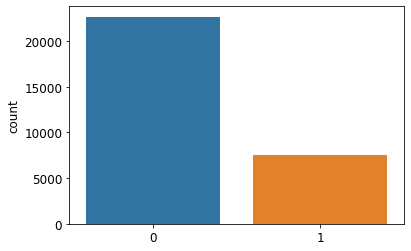

In [352]:
sns.countplot(y)
# salary -- >50k -- 1 -- above 50k
# salary -- <=50k -- 0 -- below & equalto 50k

## Loading Test Data

In [353]:
# loading test data
# removes initial space present in entire dataframe
ds_test = pd.read_csv('SalaryData_Test.csv', skipinitialspace=True)
ds_test.head()

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


In [354]:
ds_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15060 entries, 0 to 15059
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            15060 non-null  int64 
 1   workclass      15060 non-null  object
 2   education      15060 non-null  object
 3   educationno    15060 non-null  int64 
 4   maritalstatus  15060 non-null  object
 5   occupation     15060 non-null  object
 6   relationship   15060 non-null  object
 7   race           15060 non-null  object
 8   sex            15060 non-null  object
 9   capitalgain    15060 non-null  int64 
 10  capitalloss    15060 non-null  int64 
 11  hoursperweek   15060 non-null  int64 
 12  native         15060 non-null  object
 13  Salary         15060 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.6+ MB


In [355]:
print(ds_test['age'].unique())
print("\n",ds_test['workclass'].unique())
print("\n",ds_test['education'].unique())
print("\n",ds_test['educationno'].unique())

[25 38 28 44 34 63 24 55 65 36 26 48 43 20 37 45 22 23 54 32 46 56 17 29
 39 52 18 21 42 33 30 47 41 19 69 50 31 59 49 58 40 27 57 61 51 73 53 80
 62 35 72 64 68 66 60 67 71 70 90 77 81 74 78 82 75 85 76 89 83 79 88 87
 84]

 ['Private' 'Local-gov' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay']

 ['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' '5th-6th' 'Assoc-voc' '9th' 'Doctorate'
 '12th' '1st-4th' 'Preschool']

 [ 7  9 12 10  6 15  4 13 14  3 11  5 16  8  2  1]


In [356]:
print(ds_test['maritalstatus'].unique())
print("\n",ds_test['occupation'].unique())
print("\n",ds_test['relationship'].unique())
print("\n",ds_test['race'].unique())

['Never-married' 'Married-civ-spouse' 'Widowed' 'Separated' 'Divorced'
 'Married-spouse-absent' 'Married-AF-spouse']

 ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' 'Other-service'
 'Prof-specialty' 'Craft-repair' 'Adm-clerical' 'Exec-managerial'
 'Tech-support' 'Sales' 'Priv-house-serv' 'Transport-moving'
 'Handlers-cleaners' 'Armed-Forces']

 ['Own-child' 'Husband' 'Not-in-family' 'Unmarried' 'Wife' 'Other-relative']

 ['Black' 'White' 'Other' 'Amer-Indian-Eskimo' 'Asian-Pac-Islander']


In [357]:
print(ds_test['sex'].unique())
print("\n",ds_test['capitalgain'].unique())
print("\n",ds_test['capitalloss'].unique())
print("\n",ds_test['hoursperweek'].unique())

['Male' 'Female']

 [    0  7688  3103  6418  7298  3908 14084  5178 15024  2597  2907  4650
  6497  5013 27828  4934  4064  3674  2174 10605 99999  1055   114  2580
  3411  4508  4386  8614 13550  6849  2463  3137  2885  2964  1471 10566
  2354  1424  1455  3325  4416 25236  4787  2829  4865  1264  1506   594
 10520  3464 20051  4101  1797  2407  3471  2653  1086  1848 14344  1151
  2993  2290 15020  9386  2202  3818  2176  5455  3418 11678  7978  7262
  6514 41310  3456  7430  2062 34095  1831  6723  5060 15831  2977  2346
  3273  2329  9562  2105  2635  2414  4931  1731  6097   914  7896  5556
  3781  3942  2538  3887  1409 25124  7443  5721   401  1173  4687  6767
   991  2036]

 [   0 1721 1876 2415 1887  625 1977 2057 1429 1590 1485 2051 2377 1672
 1628 1902 1741 2444 1408 2001 2042 1740 1825 1848 1719 3004 2179 1573
 2205 1258 2339 1726 2258 1340 1504 2559 1668 1974 1980 1564 2547 2002
 1669 1617  323 1602 3175 2472 1579 2129 1735 2282 1870 1911 1092 1762
 2457 2231 2238  653 11

In [358]:
print(ds_test['native'].unique())
print("\n",ds_test['Salary'].unique())

['United-States' 'Peru' 'Guatemala' 'Mexico' 'Dominican-Republic'
 'Ireland' 'Germany' 'Philippines' 'Thailand' 'Haiti' 'El-Salvador'
 'Puerto-Rico' 'Vietnam' 'South' 'Columbia' 'Japan' 'India' 'Cambodia'
 'Poland' 'Laos' 'England' 'Cuba' 'Taiwan' 'Italy' 'Canada' 'Portugal'
 'China' 'Nicaragua' 'Honduras' 'Iran' 'Scotland' 'Jamaica' 'Ecuador'
 'Yugoslavia' 'Hungary' 'Hong' 'Greece' 'Trinadad&Tobago'
 'Outlying-US(Guam-USVI-etc)' 'France']

 ['<=50K' '>50K']


In [359]:
x_test = ds_test.iloc[:,:-1]
y_test = ds_test[['Salary']]

In [360]:
encoder_test = ce.OneHotEncoder(cols=['workclass','education','maritalstatus','occupation','relationship','race','sex','native'])
x_test = encoder.fit_transform(x_test)
print(x_test.shape)
x_test.head()

(15060, 102)


,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,education_1,education_2,...,native_31,native_32,native_33,native_34,native_35,native_36,native_37,native_38,native_39,native_40
0,25,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,38,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,28,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,44,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,34,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [361]:
le = LabelEncoder()
y_test = le.fit_transform(y_test)
y_test

array([0, 0, 1, ..., 0, 0, 1])

In [362]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15060 entries, 0 to 15059
Columns: 102 entries, age to native_40
dtypes: int64(102)
memory usage: 11.7 MB


## Model Training/Testing

### Without Scaling

Without scaling input
Training data Accuracy = 0.8032
Test data Accuracy =  0.7719


,Data,Model,Accuracy,Class,Precision,Recall,F1_score
0,Training Data w/o Scaling,Gaussian NB,0.8032,below= 50K,0.9267,0.8013,0.8594
1,,,,above 50k,0.5743,0.8089,0.6717
2,Test Data w/o Scaling,Gaussian NB,0.7719,below= 50K,0.8418,0.8591,0.8503
3,,,,above 50k,0.5382,0.5043,0.5207


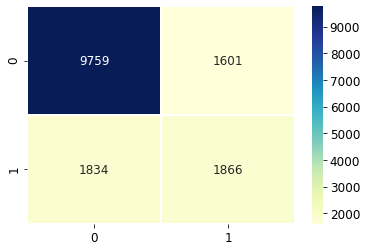

In [363]:
gnb  = GaussianNB()
gnb.fit(x,y)

print("Without scaling input")
y_predict = gnb.predict(x)
acc_wo_scaled_train = round(accuracy_score(y,y_predict),4)
print("Training data Accuracy =",acc_wo_scaled_train)
#print(classification_report(y,y_predict))
report_train = classification_report(y,y_predict, output_dict=True)
#rint(report_train)

y_predict_test = gnb.predict(x_test)
acc_wo_scaled_test = round(accuracy_score(y_test,y_predict_test),4)
print("Test data Accuracy = ", acc_wo_scaled_test)
#print(classification_report(y_test,y_predict_test))
report_test = classification_report(y_test,y_predict_test,output_dict=True)
#print(report_test)

#Confusion matrix
cm_wo_scaling = confusion_matrix(y_test,y_predict_test)
sns.heatmap(cm_wo_scaling, annot=True, fmt='d', cmap='YlGnBu', linewidths=1)

colNames = ['Data','Model','Accuracy','Class','Precision','Recall','F1_score']

# table for displaying precision, recall , f1score from Classification report
Accuracy_table = pd.DataFrame(columns=colNames)

Accuracy_table['Data']      = ["Training Data w/o Scaling","", "Test Data w/o Scaling",""]
Accuracy_table['Model']     = ["Gaussian NB","", "Gaussian NB",""]
Accuracy_table['Accuracy']  = [round(acc_wo_scaled_train,4),"",round(acc_wo_scaled_test,4),""]
Accuracy_table['Class']     = ["below= 50K","above 50k","below= 50K","above 50k"]

Accuracy_table['Precision'] = [round(report_train['0']['precision'],4),round(report_train['1']['precision'],4), 
                                round(report_test['0']['precision'],4),round(report_test['1']['precision'],4)]

Accuracy_table['Recall'] = [round(report_train['0']['recall'],4),round(report_train['1']['recall'],4), 
                                round(report_test['0']['recall'],4),round(report_test['1']['recall'],4)]

Accuracy_table['F1_score']  = [round(report_train['0']['f1-score'],4),round(report_train['1']['f1-score'],4), 
                                round(report_test['0']['f1-score'],4),round(report_test['1']['f1-score'],4)]

Accuracy_table

0.6816956128663875


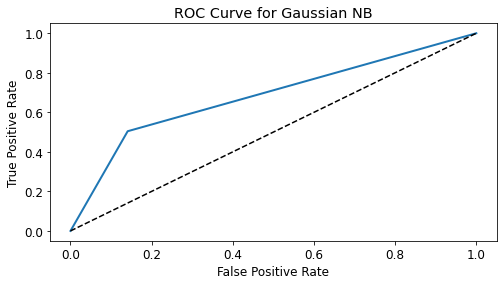

In [364]:
auc = roc_auc_score(y_test,y_predict_test)
print(auc)

fpr, tpr, thresholds = roc_curve(y_test,y_predict_test)
plt.figure(figsize=(8,4))
plt.plot(fpr,tpr,linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Gaussian NB")
plt.show()

### With Scaling

For Scaled Input
Training Data Accuracy 0.5538
Test Data Accuracy =  0.7543


,Data,Model,Accuracy,Class,Precision,Recall,F1_score
0,Training Data w/o Scaling,Gaussian NB,0.8032,below= 50K,0.9267,0.8013,0.8594
1,,,,above 50k,0.5743,0.8089,0.6717
2,Test Data w/o Scaling,Gaussian NB,0.7719,below= 50K,0.8418,0.8591,0.8503
3,,,,above 50k,0.5382,0.5043,0.5207
0,Training Data with Scaling,Gaussian NB,0.5538,below= 50K,0.9616,0.4228,0.5873
0,,,,above 50K,0.3527,0.9491,0.5143
0,Test Data with Scaling,Gaussian NB,0.7543,below= 50K,0.7543,1.0000,0.8600
0,,,,above 50K,0.0000,0.0000,0.0000


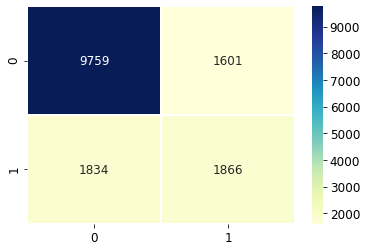

In [365]:
scaler        = StandardScaler()
scaled_x      = scaler.fit_transform(x)
scaled_x_test = scaler.fit_transform(x_test)
#print(scaled_x_test)

gnb = GaussianNB()
gnb.fit(scaled_x,y)

print("For Scaled Input")
y_predict_scaled      = gnb.predict(scaled_x)
acc_with_scaled_train = round(accuracy_score(y,y_predict_scaled),4)
print("Training Data Accuracy", acc_with_scaled_train)
#print(classification_report(y,y_predict_scaled))
report_train_scaled   = classification_report(y,y_predict_scaled,output_dict=True)

y_predict_scaled_test     = gnb.predict(scaled_x_test)
acc_with_scaled_test      = round(accuracy_score(y_test,y_predict_scaled_test),4)
print("Test Data Accuracy = ", acc_with_scaled_test)
report_test_scaled        = classification_report(y_test,y_predict_scaled_test,output_dict=True)
#print(classification_report(y_test,y_predict_scaled_test))

#Confusion matrix
cm_with_scaling = confusion_matrix(y_test,y_predict_scaled_test)
sns.heatmap(cm_wo_scaling, annot=True, fmt='d', cmap='YlGnBu', linewidths=1)


Accuracy_table=Accuracy_table.append(pd.DataFrame(data=
                                    [["Training Data with Scaling","Gaussian NB",round(acc_with_scaled_train,4),"below= 50K",
                                      round(report_train_scaled['0']['precision'],4),round(report_train_scaled['0']['recall'],4),
                                      round(report_train_scaled['0']['f1-score'],4)]],
                                        columns= colNames))
Accuracy_table=Accuracy_table.append(pd.DataFrame(data=
                                    [["","","","above 50K",
                                      round(report_train_scaled['1']['precision'],4),round(report_train_scaled['1']['recall'],4),
                                      round(report_train_scaled['1']['f1-score'],4)]],
                                        columns=colNames ))
Accuracy_table=Accuracy_table.append(pd.DataFrame(data=
                                    [["Test Data with Scaling","Gaussian NB",round(acc_with_scaled_test,4),"below= 50K",
                                      round(report_test_scaled['0']['precision'],4),round(report_test_scaled['0']['recall'],4),
                                      round(report_test_scaled['0']['f1-score'],4)]],
                                        columns=colNames))
Accuracy_table=Accuracy_table.append(pd.DataFrame(data=
                                    [["","","","above 50K",
                                      round(report_test_scaled['1']['precision'],4),round(report_test_scaled['1']['recall'],4),
                                      round(report_test_scaled['1']['f1-score'],4)]],
                                        columns= colNames ))

Accuracy_table

0.5


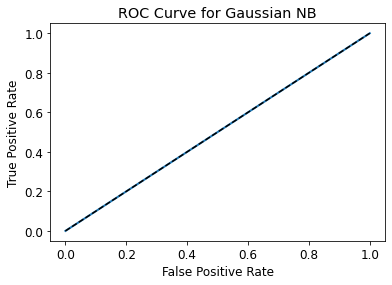

In [366]:
auc = roc_auc_score(y_test,y_predict_scaled_test)
print(auc)

fpr, tpr, thresholds = roc_curve(y_test,y_predict_scaled_test)
plt.figure(figsize=(6,4))
plt.plot(fpr,tpr,linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Gaussian NB")
plt.show()

# there is no separabability between the classes of salary
# the model fails

## Inferences

* loaded the dataset for train data and test data
* There are 30161 observations & 14 features for train data
* There are 15060 observations & 14 features for test data
*     response variable = salary -- >50k -- 1 -- above 50k
*                         salary -- <=50k -- 0 -- below & equalto 50k
* Converted 9 categorical variables using one hot encoding for both train & test data
* Converted response variable to binary class using label encoder for both train & test data
* Used Gaussian Naive Bayes model for classification of salary data
* Implemented Gaussian NB mdoel without and with scaled data
* Calculated Accuracy, plotted graph for confusion Matrix and ROC curve for the test data
        
* CONCLUSION

* Accuracy score was better for both training & test data without scaling
* Training accuray = 80%
* Test Accuracy    = 77%
* Test accuracy was little less as compared to training accuracy, so overfitting of data was observed.

* FOR TEST DATA

* True Positive rate was 84% , ie 84% of the predicted salary below or equal to 50k was predicted correctly.
* From ROC curve 68% of separability between the classes of salary was observed
* ie. The model is able to differentiate between the classes of salary (below 50k & above 50k) is 64%.
